In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# Define Parameters
NUM_CLASS = 5
IMG_SIZE = 224

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


In [4]:
# download from google drive or upload file by yourself
!pip install --upgrade gdown
!gdown --fuzzy '1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7' --output retina-dataset.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7
From (redirected): https://drive.google.com/uc?id=1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7&confirm=t&uuid=d9be1699-5104-451c-85bc-ba9ba588c2e8
To: /content/retina-dataset.zip
100% 622M/622M [00:12<00:00, 49.6MB/s]


In [5]:
# unzip dataset file
!unzip -q retina-dataset.zip

#### Data Visualization

In [6]:
df = pd.read_csv("kaggle_retina/train.csv")
df.head()

,id_code,diagnosis
0,c1e6fa1ad314,1
1,ed246ae1ed08,4
2,4d3de40ced3a,0
3,ae8472f8d310,1
4,3c28fd846b43,0


In [7]:
paths = glob('kaggle_retina/train/*.png')
paths_test = sorted(glob('kaggle_retina/test/*.png'))
len(paths), len(paths_test)

(2197, 1465)

kaggle_retina/train/495106ae3b68.png
label: 0


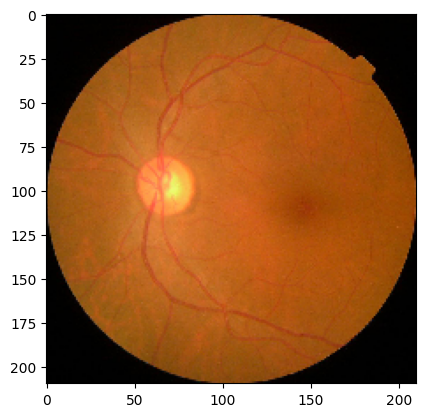

In [8]:
idx = np.random.randint(0, len(df))
row = df.iloc[idx]
filename = row["id_code"]
path = f"kaggle_retina/train/{filename}.png"
img = cv2.imread(path)[:,:,::-1]
plt.imshow(img)
print(path)
print(f'label: {row["diagnosis"]}')

In [9]:
all_cls = df['diagnosis'].tolist()
print(all_cls[:3])

[1, 4, 0]


<BarContainer object of 5 artists>

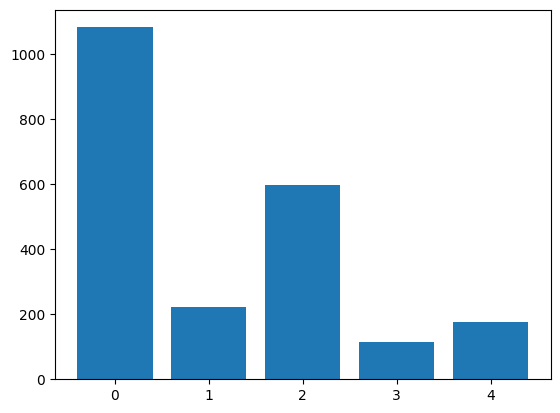

In [10]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### [TODO] Dataset, DataLoader

Dataset & Data augumentation

#### Dataset & DataLoader


*   [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset)



*   Must implement

    1.   **\_\_len\_\_()**: size of dataset
    2.   **\_\_getitem\_\_()**: load a data sample for a given index

*   __getitem__() steps:
    1. Get image path
    2. Read image, resize
    3. Real image label
    4. convert image to tesnor and rescale to 0~1


ref: [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)


In [11]:
import imgaug.augmenters as iaa
import imgaug as ia

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, img_size, df, aug):
        self.img_paths = img_paths
        self.img_size = img_size
        self.df = df

        self.seq = seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Flipud(0.5), # 50% vertical flip
            iaa.Affine(
                rotate=(-10, 10), # random rotate -10 ~ +10 degree
                shear=(-16,16), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])
        self.aug = aug
    def __len__(self):
        """number of samples"""
        return len(self.img_paths)

    def __getitem__(self, idx):
        """read 1 sample"""
        # Read img
        row = df.iloc[idx]
        filename = row["id_code"]
        path = f"kaggle_retina/train/{filename}.png" # get img path
        img = cv2.imread(path) # read img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
        img = cv2.resize(img, (self.img_size, self.img_size)) # Resize iamge
        if self.aug:
            img = self.seq.augment_image(img)
        img = img / 255. # 0~255 -> 0.~1.

        # Read class index
        cls_idx = row['diagnosis']

        # transform img to tensor
        img = torch.tensor(img, dtype=torch.float)
        # channel last -> channel first
        # np.swapaxis()
        img = img.permute(2, 0, 1) # (H, W, C) -> (C, H, W)

        cls_idx = torch.tensor(cls_idx, dtype=torch.long)

        return img, cls_idx

In [13]:
# Build training and validation dataset
df = pd.read_csv('kaggle_retina/train.csv')
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1968)
train_ds = Dataset(paths, IMG_SIZE, train_df, aug=True)
val_ds = Dataset(paths_test, IMG_SIZE, val_df,aug=False)

In [14]:
# Number of samples
len(train_ds), len(val_ds)

(2197, 1465)

In [15]:
# Build DataLoaders
BATCH_SIZE = 50
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)

torch.Size([3, 224, 224]) tensor(1)


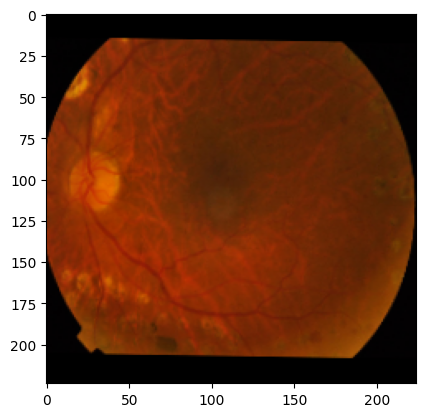

In [16]:
img, label = train_ds[0]
print(img.shape, label)

img = img.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
plt.imshow(img)
plt.show()

In [17]:
img, label

(tensor([[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]),
 tensor(1))

#### [TODO] Model

In [38]:
# 繼承nn.Module,初始__init__化定義有哪些層（參數輸入input channel數,output channel數）,forward函數定義從資料進來到出去的步驟。
class ConvBN(nn.Module):
    def __init__(self, cin, cout, kernel_size = 3):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, kernel_size, padding='same')
        self.bn = nn.BatchNorm2d(num_features=cout)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.act(x)

class CNN(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBN(3, 16, kernel_size ),
            ConvBN(16, 16, kernel_size),
            nn.MaxPool2d(kernel_size=2),

            ConvBN(16, 32, kernel_size),
            ConvBN(32, 32, kernel_size),
            nn.MaxPool2d(kernel_size=2),

            ConvBN(32, 64,kernel_size),
            ConvBN(64, 64,kernel_size),
            nn.MaxPool2d(kernel_size=2),
        )
        self.flatten = nn.Flatten() # 輾平後特徵數量為通道＊長＊寬，其中長寬要計算卷幾過程中的改變
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64*28*28, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, NUM_CLASS),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [51]:
# Build a model and move to GPU device
model = CNN(kernel_size=3).to(device)

In [52]:
model

CNN(
  (encoder): Sequential(
    (0): ConvBN(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (1): ConvBN(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvBN(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (4): ConvBN(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (5): MaxPool2d(kernel_size=2, s

In [53]:
from torchsummary import summary # model summary
# Model summary
summary(model, (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            ConvBN-4         [-1, 16, 224, 224]               0
            Conv2d-5         [-1, 16, 224, 224]           2,320
       BatchNorm2d-6         [-1, 16, 224, 224]              32
              ReLU-7         [-1, 16, 224, 224]               0
            ConvBN-8         [-1, 16, 224, 224]               0
         MaxPool2d-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 32, 112, 112]           4,640
      BatchNorm2d-11         [-1, 32, 112, 112]              64
             ReLU-12         [-1, 32, 112, 112]               0
           ConvBN-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 32, 1

#### [TODO] Training

In [54]:
# 定義損失函數與激活函數
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                            lr=1e-3)

In [55]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [56]:
from tqdm.auto import tqdm
EPOCHS = 100

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
erly_stop = 5
best_loss = np.inf
counter = 0
best_model = model
# np.inf-無限大
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ', counter)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    if val_loss < best_loss:
      counter = 0
      best_loss = val_loss
      best_model = model
    elif counter < erly_stop:
      counter += 1
    else:
      print('early stop')
      break
model = best_model


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 4.1240, train_acc: 0.464     val_loss: 1.1733, val_acc: 0.569  0


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 1.1773, train_acc: 0.590     val_loss: 1.0001, val_acc: 0.647  0


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 1.0820, train_acc: 0.607     val_loss: 0.9557, val_acc: 0.652  0


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 1.0408, train_acc: 0.626     val_loss: 0.9152, val_acc: 0.673  0


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 1.0244, train_acc: 0.644     val_loss: 0.8566, val_acc: 0.682  0


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 0.9689, train_acc: 0.655     val_loss: 0.8568, val_acc: 0.689  0


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 0.9547, train_acc: 0.658     val_loss: 0.9145, val_acc: 0.673  1


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 0.9327, train_acc: 0.662     val_loss: 0.9328, val_acc: 0.661  2


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 0.9240, train_acc: 0.672     val_loss: 0.8034, val_acc: 0.698  3


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0009     train_loss: 0.9079, train_acc: 0.669     val_loss: 0.9165, val_acc: 0.683  0


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0010     train_loss: 0.8846, train_acc: 0.676     val_loss: 1.0104, val_acc: 0.638  1


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0011     train_loss: 0.8808, train_acc: 0.686     val_loss: 0.7935, val_acc: 0.706  2


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0012     train_loss: 0.8390, train_acc: 0.694     val_loss: 0.8589, val_acc: 0.692  0


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0013     train_loss: 0.8813, train_acc: 0.688     val_loss: 0.8760, val_acc: 0.681  1


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0014     train_loss: 0.8543, train_acc: 0.699     val_loss: 0.9389, val_acc: 0.647  2


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0015     train_loss: 0.8544, train_acc: 0.685     val_loss: 0.8039, val_acc: 0.700  3


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0016     train_loss: 0.8465, train_acc: 0.695     val_loss: 0.8466, val_acc: 0.683  4


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH: 0017     train_loss: 0.8478, train_acc: 0.701     val_loss: 0.8651, val_acc: 0.695  5
early stop


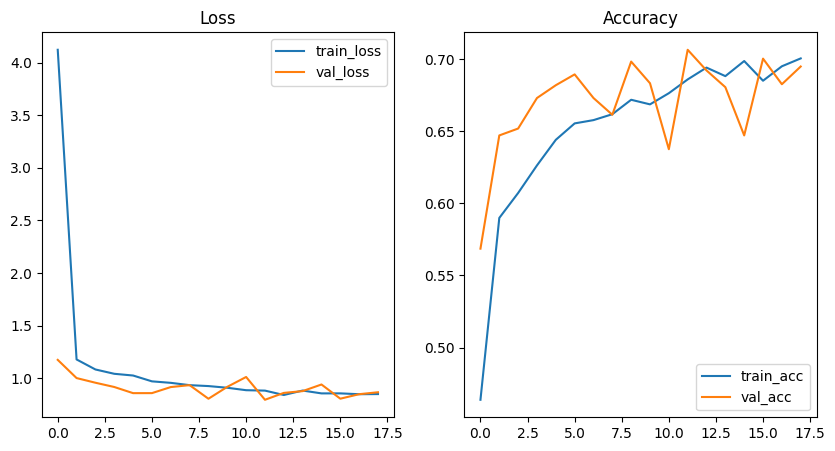

In [57]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
# plot acc
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

In [58]:
# Save model weights
PATH = './model_weights.pth'
torch.save(model.state_dict(), PATH)

In [59]:
model = CNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [60]:
torch.save(model, 'model.pth')

model = torch.load('model.pth')

In [61]:
model = model.to(device) # move model to GPU
model.eval() # Set model to evaluation mode
# Create temp tensor
y_true = torch.tensor([], dtype=torch.long).to(device)
y_pred_logits = torch.tensor([]).to(device)

# deactivate autograd engine and reduce memory usage and speed up computations
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        # Concatenate Ground truth and prediction
        y_true = torch.cat((y_true, y), dim=0)
        y_pred_logits = torch.cat((y_pred_logits, pred), dim=0)

y_pred_cls = y_pred_logits.argmax(1) # get class idx with max prob (100, 3) -> (100, )
y_pred_probs = nn.Softmax(dim=1)(y_pred_logits) # convert logits to probability

# Move tensor to CPU and convert to np.ndarray
y_true = y_true.cpu().numpy()
y_pred_cls = y_pred_cls.cpu().numpy()
y_pred_probs = y_pred_probs.cpu().numpy()

In [62]:
# Shape
y_true.shape, y_pred_probs.shape, y_pred_cls.shape

((1465,), (1465, 5), (1465,))

In [63]:
# calculate ACC
acc = sum(y_true == y_pred_cls) / len(y_true)
acc

0.6948805460750853

#### Kaggle Submission

https://www.kaggle.com/competitions/diabetic-retinopathy-classification-3/overview